## Assignment for Week 6 - K-Means and Hierarchical Clustering

### Exerise:
#### KMeans and Hierarchial Clustering

Collect data from twitter using your choice of hashtag (at least 1000 tweets). 
To gather your Twitter data, I would recommend using the python library tweepy.<br>
Note: Reddit data can be used instead of Twitter data for this assignment.

- You will use both K-Means and HCA to cluster the collected data
- Draw a dendrogram
- Identify number of optimum clusters, and justify how do you pick number of clusters
- List the top 10 most frequent words
- Visualize using wordclouds
- Summarize your findings

In [2]:
%%bash
declare -a DATA_FILES=("data/wholesale-customers-data.csv")

for FILE in "${DATA_FILES[@]}"; do
    if [ -f "${FILE}" ] ; then
        echo "${FILE}:"
        echo "    Data file size:      $(du -h ${FILE} | awk '{print $1;}')"
        echo "    Data file type:      $(file --brief ${FILE})"
        echo "    Number of lines:     $(wc -l ${FILE} | awk '{print $1;}')"
        echo "    Data header row?     $(head -n 1 ${FILE})"
    else
        echo "${FILE}: NOT FOUND"
    fi
done

2022-02-20 02:09:08 - DEBUG   -    asyncio - Using selector: EpollSelector


data/wholesale-customers-data.csv:
    Data file size:      16K
    Data file type:      CSV text
    Number of lines:     441
    Data header row?     Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen


In [21]:
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn.cluster
import sklearn.decomposition
import sklearn.feature_extraction.text
import sklearn.manifold
import sklearn.metrics
import sklearn.pipeline
import tweets
import wordcloud

# Activate the 'inline' backend such that plots are displayed directly
# after the cell containing the plot command
%matplotlib inline

# Display up to 100 rows
pd.options.display.max_rows = 100

# Set up logging ...
logging.basicConfig(format='%(asctime)s - %(levelname)-7s - %(name)10s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.DEBUG)
for logger in ['matplotlib', 'tweepy.api', 'requests_oauthlib', 'oauthlib', 'urllib3']:
    logging.getLogger(logger).setLevel(logging.ERROR)

LOGGER = logging.getLogger('MSDS-680')

RANDOM_SEED     = 42
MAX_CLUSTERS    = 30

def kmeans_metrics(df, max_k=MAX_CLUSTERS):
    metrics_df = pd.DataFrame()

    for k in range(2, max_k + 1):
        model = sklearn.cluster.KMeans(n_clusters=k, random_state=RANDOM_SEED)
        model.fit(df)

        # predictions = model.predict(df)
        wcss        = -model.score(df)
        silhouette  = sklearn.metrics.silhouette_score(df, model.labels_)

        LOGGER.debug(f'With k={k:3d} ... wcss: {wcss:.3f}, silhouette: {silhouette:.3f}')

        metrics_df = pd.concat([metrics_df,
                                pd.DataFrame([{'k': k, 'wcss': wcss, 'silhouette': silhouette }])],
                               ignore_index=True)

    return metrics_df

def plot_kmeans_metrics(df):
    # Matplotlib annotation code courtesy of StackOverflow.com (2017)
    fig, ax = plt.subplots()

    x       = df['k']
    y       = df['silhouette']
    x_max   = x[np.argmax(y)]
    y_max   = y.max()

    text = f'k={x_max}, silhouette={y_max:.3f}'
    kw  = dict(xycoords     = 'data',
            textcoords   = "axes fraction",
            arrowprops   = dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=60"),
            bbox         = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72),
            ha           = "right",
            va           = "top")
    ax.annotate(text, xy=(x_max, y_max), xytext=(0.94, 0.96), **kw)

    ax.set_xlim(0, x.max() * 1.3)
    ax.set_ylim(0, y_max * 1.3)
    ax.set_title('Silhouette vs Number of Clusters')
    plt.scatter(x, y)

    fig, ax = plt.subplots()
    ax.set_title('WCSS vs Number of Clusters')
    plt.scatter(x, df['wcss'])

    fig, ax = plt.subplots()
    ax.set_title('Delta WCSS vs Number of Clusters')
    plt.scatter(x[:-1], np.diff(df['wcss']))


def plot_wordclouds(df, labels=None, label_column='topic', text_column='transformed_text'):
    labels = labels or df[label_column].unique()
    for lbl in labels:
        rows        = ' '.join(df[df[label_column] == lbl][text_column])
        words       = rows.split()
        word_freq   = pd.Series(words).value_counts().to_dict()
        wc          = wordcloud.WordCloud(width=1000, height=600, max_words=200).generate_from_frequencies(word_freq)

        LOGGER.info(f'Word cloud for label "{lbl}"')

        plt.figure(figsize=(10, 10))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.show()

In [3]:
wholesale_df = pd.read_csv('data/wholesale-customers-data.csv')
LOGGER.info(f'credit_df.shape ==> {wholesale_df.shape[0]} rows x {wholesale_df.shape[1]} cols')
wholesale_df.head()


2022-02-20 02:09:59 - INFO    -   MSDS-680 - credit_df.shape ==> 440 rows x 8 cols


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
wholesale_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [6]:
wholesale_df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


2022-02-20 02:43:31 - DEBUG   -   MSDS-680 - With k=  2 ... wcss: 1954.648, silhouette: 0.614
2022-02-20 02:43:31 - DEBUG   -   MSDS-680 - With k=  3 ... wcss: 1607.675, silhouette: 0.538
2022-02-20 02:43:32 - DEBUG   -   MSDS-680 - With k=  4 ... wcss: 1325.979, silhouette: 0.404
2022-02-20 02:43:32 - DEBUG   -   MSDS-680 - With k=  5 ... wcss: 1058.771, silhouette: 0.369
2022-02-20 02:43:32 - DEBUG   -   MSDS-680 - With k=  6 ... wcss: 915.723, silhouette: 0.377
2022-02-20 02:43:32 - DEBUG   -   MSDS-680 - With k=  7 ... wcss: 822.976, silhouette: 0.302
2022-02-20 02:43:33 - DEBUG   -   MSDS-680 - With k=  8 ... wcss: 751.774, silhouette: 0.304
2022-02-20 02:43:33 - DEBUG   -   MSDS-680 - With k=  9 ... wcss: 659.465, silhouette: 0.306
2022-02-20 02:43:33 - DEBUG   -   MSDS-680 - With k= 10 ... wcss: 628.356, silhouette: 0.300
2022-02-20 02:43:33 - DEBUG   -   MSDS-680 - With k= 11 ... wcss: 544.854, silhouette: 0.312
2022-02-20 02:43:33 - DEBUG   -   MSDS-680 - With k= 12 ... wcss: 

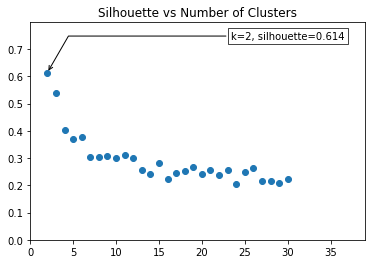

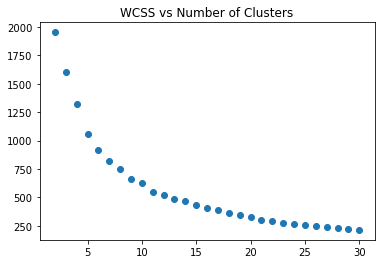

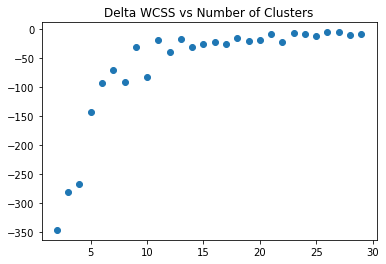

In [26]:
label_cols      = ['Channel', 'Region']
feature_cols    = [c for c in wholesale_df.columns if not c in label_cols]

X = wholesale_df[feature_cols]

scaler = sklearn.preprocessing.StandardScaler()
Xt = scaler.fit_transform(X)

metrics_df = kmeans_metrics(Xt)
plot_kmeans_metrics(metrics_df)


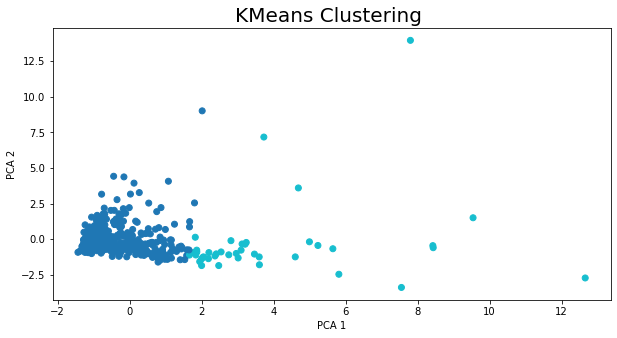

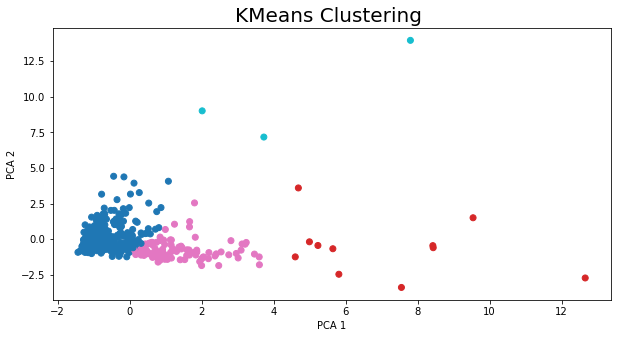

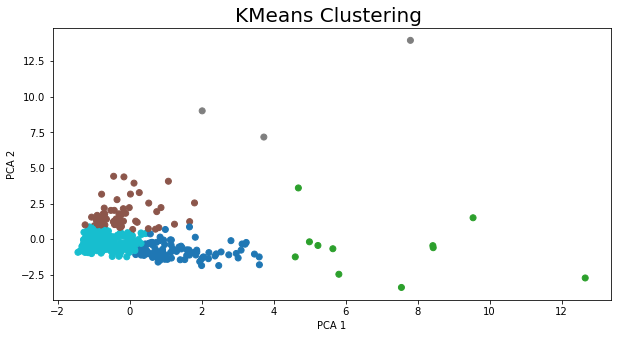

In [38]:

for k in [2, 4, 5]:
    #K Means Clustering
    pca = sklearn.decomposition.PCA(2)
    Xpca = pca.fit_transform(Xt)
    Xpca_df = pd.DataFrame(Xpca)

    model = sklearn.cluster.KMeans(n_clusters=k, random_state=RANDOM_SEED)
    model.fit(Xpca_df)
    predictions = model.predict(Xpca_df)

    plt.figure(figsize=(10,5))
    plt.title("KMeans Clustering ",fontsize=20)
    plt.scatter(Xpca_df[0], Xpca_df[1], c=predictions, cmap='tab10')
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()


In [30]:
Xpca

array([[ 1.93290546e-01, -3.05099963e-01],
       [ 4.34419896e-01, -3.28412623e-01],
       [ 8.11143234e-01,  8.15095701e-01],
       [-7.78647832e-01,  6.52753734e-01],
       [ 1.66287259e-01,  1.27143372e+00],
       [-1.56169932e-01, -2.95140988e-01],
       [-3.35288404e-01, -5.25003258e-01],
       [ 1.40586434e-01, -2.30992687e-01],
       [-5.17319541e-01, -6.59362827e-01],
       [ 1.59210908e+00, -7.41011332e-01],
       [ 6.38085945e-01, -4.01825201e-01],
       [-9.27692579e-01, -2.19287242e-01],
       [ 9.91362176e-01,  6.85910808e-01],
       [ 8.50246760e-01, -8.56919642e-02],
       [ 8.45043794e-01,  1.54724325e-01],
       [-9.51585375e-01, -4.95908498e-01],
       [ 5.57558717e-01, -1.02612272e+00],
       [-3.52538598e-01,  2.07075910e-01],
       [ 3.16578563e-01,  4.42066292e-01],
       [-3.23755737e-01, -7.03586946e-01],
       [-3.20000597e-01,  1.56628147e-01],
       [-1.11844720e+00, -2.30527519e-01],
       [-1.76694545e-01,  2.14371699e+00],
       [ 4.

# References

StackOverflow.com (2017, April).  How to automatically annotate maximum value in pyplot.  Retrieved from https://stackoverflow.com/questions/43374920/how-to-automatically-annotate-maximum-value-in-pyplot

Mysiak, K. (2020, July). Explaining K-Means clustering.  Retrieved from https://towardsdatascience.com/explaining-k-means-clustering-5298dc47bad6